In [140]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
from datetime import datetime
now = datetime.now

In [141]:
class KMeans:
    def __init__(self, n_clusters, max_iter=100, atol=.1, method='lyod', **kwargs):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.atol = atol
        self.method = method
        self.centroids = None
        self.centroids_history = []
        self.distance_computations = 0
        for kw, kwarg in kwargs.items():
            setattr(self, kw, kwarg)

    def fit(self, X):
        if self.method == 'lyod':
            self.centroids = self._initialize_centroids(X)
            
            for _ in range(self.max_iter):
                self.centroids_history.append(self.centroids)
                labels = self._assign_labels(X, self.centroids)
                new_centroids = self._update_centroids(X, labels)

                if np.allclose(new_centroids, self.centroids, atol=self.atol):
                    break

                self.centroids = new_centroids
        elif self.method == 'lsh':
            pass
        elif self.method == 'coresets':
            pass     

    def predict(self, X):
        if self.method == 'lyod':
            distances = cdist(X, self.centroids)
            labels = np.argmin(distances, axis=1)
        elif self.method == 'lsh':
            pass
        elif self.method == 'coresets':
            pass      
        return labels

    def _initialize_centroids(self, X):
        random_indices = np.random.choice(range(X.shape[0]), size=self.n_clusters, replace=False)
        centroids = X[random_indices]
        return centroids

    def _assign_labels(self, X, centroids):
        distances = cdist(X, centroids)
        self.distance_computations += len(X) * self.n_clusters
        labels = np.argmin(distances, axis=1)
        return labels

    def _update_centroids(self, X, labels):
        unique_labels = np.unique(labels)
        centroids = np.zeros((self.n_clusters, X.shape[1]))

        for i, label in enumerate(unique_labels):
            cluster_points = X[labels == label]
            centroids[i] = np.mean(cluster_points, axis=0)

        return centroids

In [142]:
def convergence_plot(centroids_history):
    fig, ax = plt.subplots()
    centroid_distances = np.ndarray(
        (len(centroids_history)-1, len(centroids_history[0]))
    )
    for i, iteration in enumerate(centroids_history[:-1]):
        next_iteration = centroids_history[i+1]
        for j in range(len(iteration)):
            centroid_distances[i, j] = np.linalg.norm(
                iteration[j] - next_iteration[j]
            )

    for history in centroid_distances.T:
        ax.plot(history)
    
    return fig, ax

In [143]:
def benchmark(X, k, runs, method, title, **kwargs):
    acc_seconds = 0
    acc_nmi = 0
    for i in range(runs):
        model = KMeans(k, atol=500, method=method, **kwargs)
        t0 = now()
        model.fit(X)
        t0 = now() - t0
        acc_seconds += t0.seconds
        iterations = len(model.centroids_history)
        nmi = normalized_mutual_info_score(y, model.predict(X), average_method='arithmetic')
        acc_nmi += nmi
        fig, ax = convergence_plot(model.centroids_history)
        ax.set_title(
            f'{title}\n'
            f'Run: {i}\n'
            f'Runtime: {t0.seconds} seconds\n'
            f'NMI: {round(nmi, 2)}\n'
            f'Iterations: {iterations}\n'
            f'Distance Computations: {model.distance_computations:.2e}'
    )
    return acc_nmi/runs, acc_seconds/runs

In [144]:
df = pd.read_csv('bio_train.csv', header=None)
y = df.iloc[:, 0].to_numpy()# block ids
X = df.iloc[:, 1:].to_numpy() # features


In [145]:
k = np.unique(y).size # amount unique block ids

In [146]:
report = {}

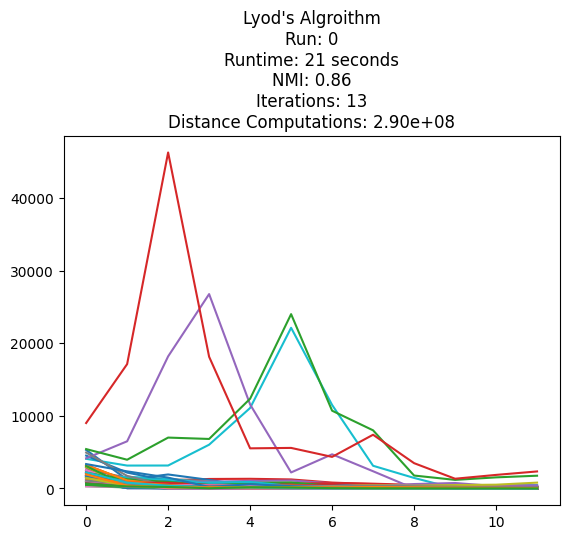

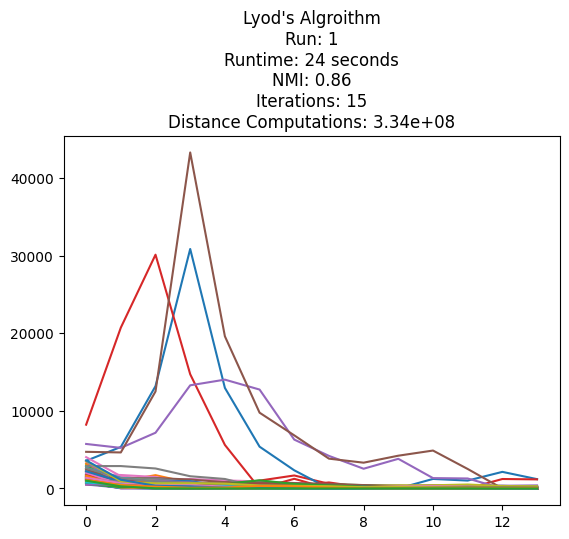

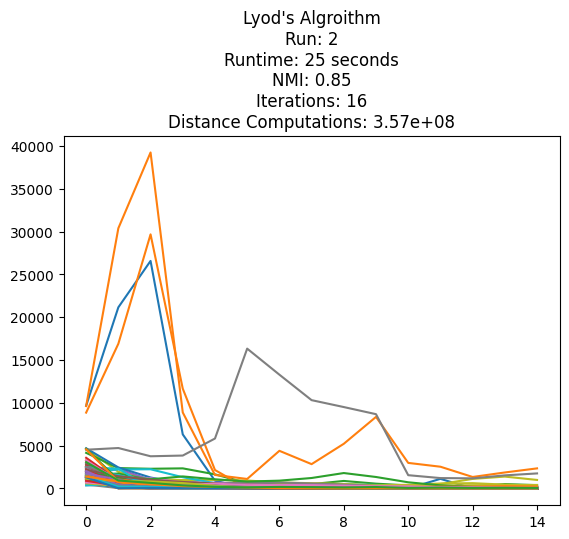

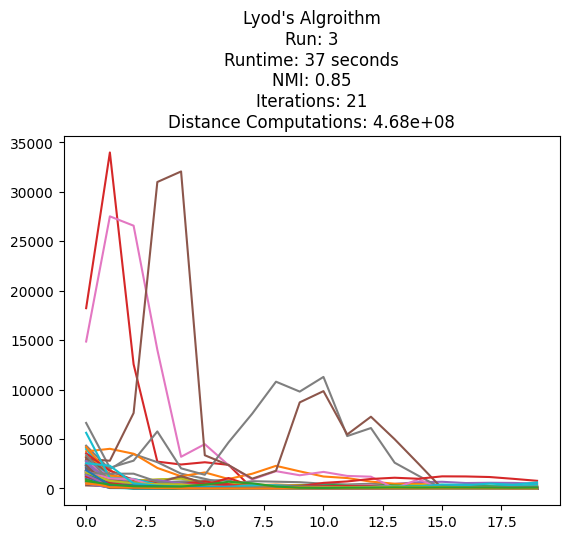

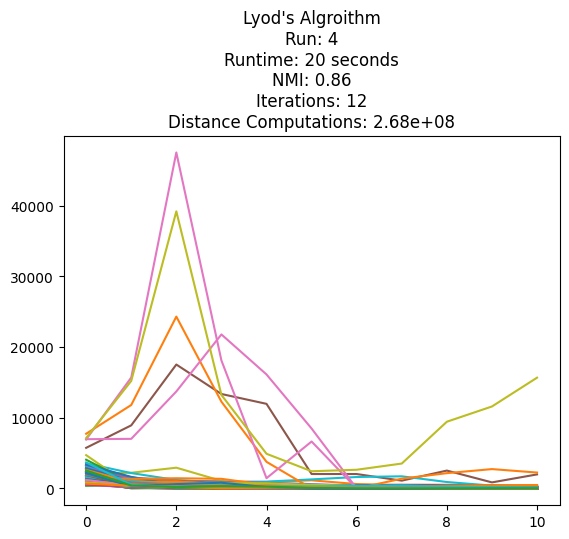

In [147]:
lyod_title = 'Lyod\'s Algroithm'
report[lyod_title] = benchmark(X, k, 5, method='lyod', title=lyod_title)

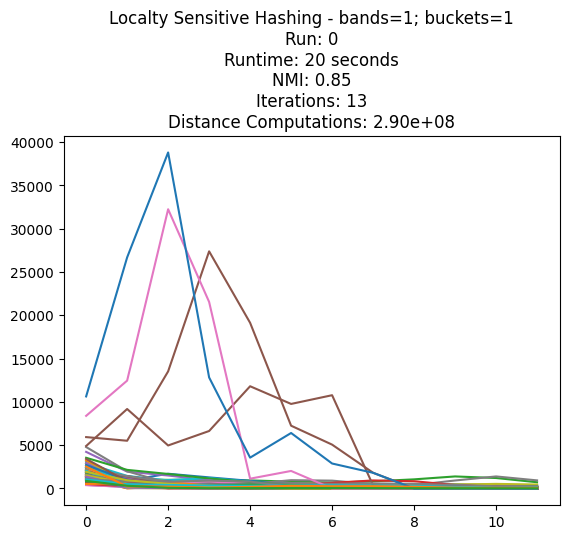

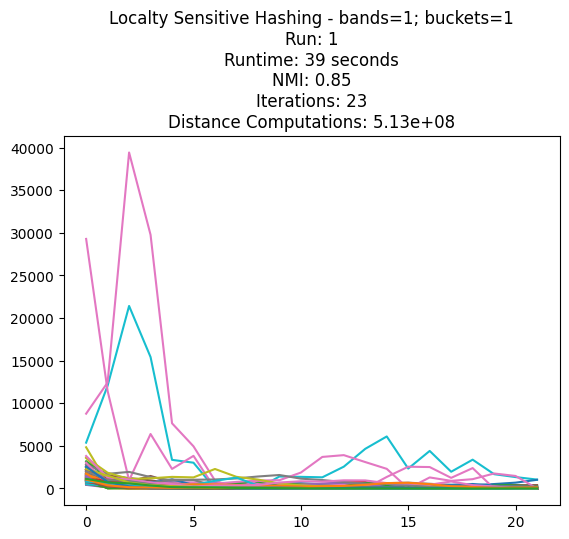

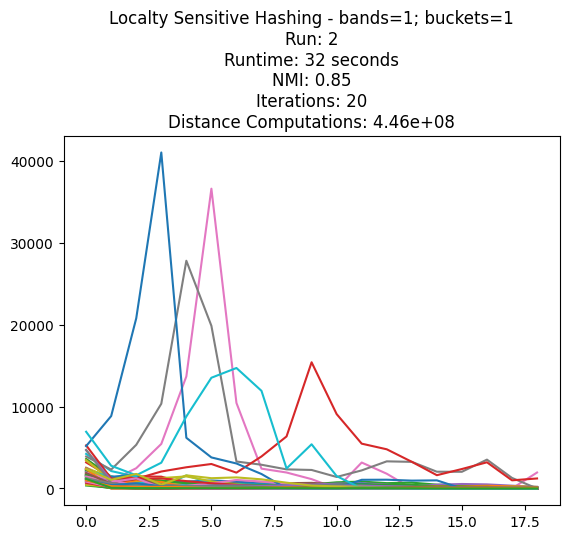

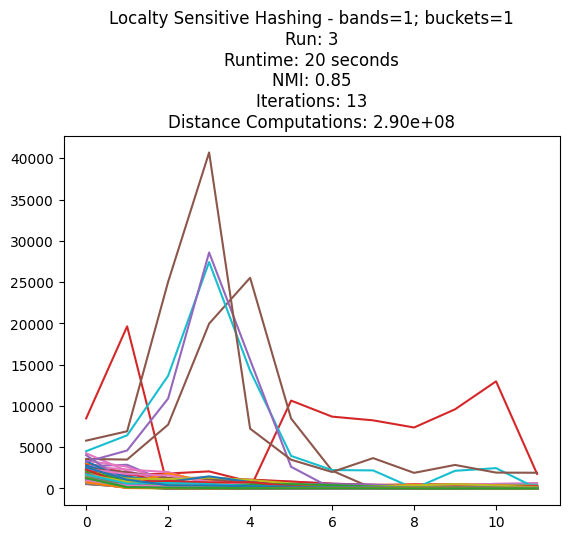

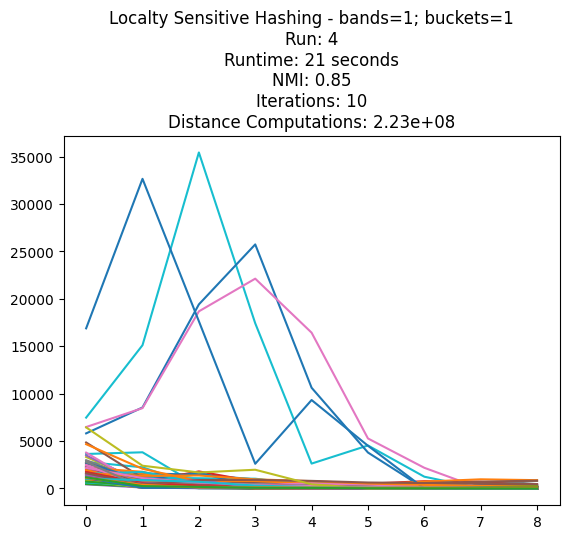

In [148]:
for bands in 1,:
    for buckets in 1,:
        lsh_title = f'Locality Sensitive Hashing - bands={bands}; buckets={buckets}'
        # report[lsh_title] = benchmark(X, k, 5, method='lsh', title=lsh_title, bands=bands, buckets=buckets)
        report[lsh_title] = benchmark(X, k, 5, method='lyod', title=lsh_title, bands=bands, buckets=buckets)

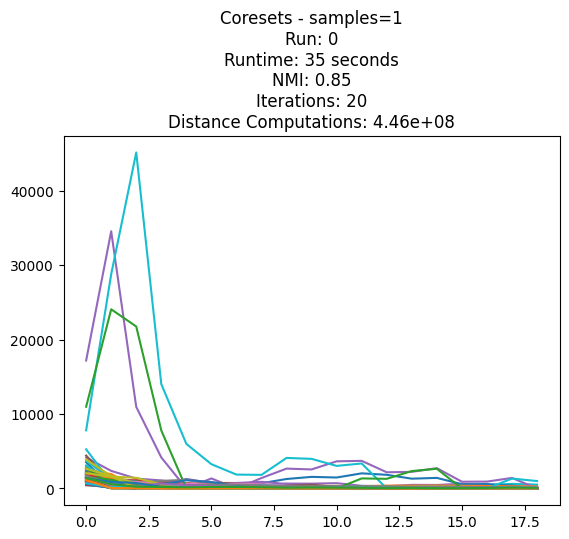

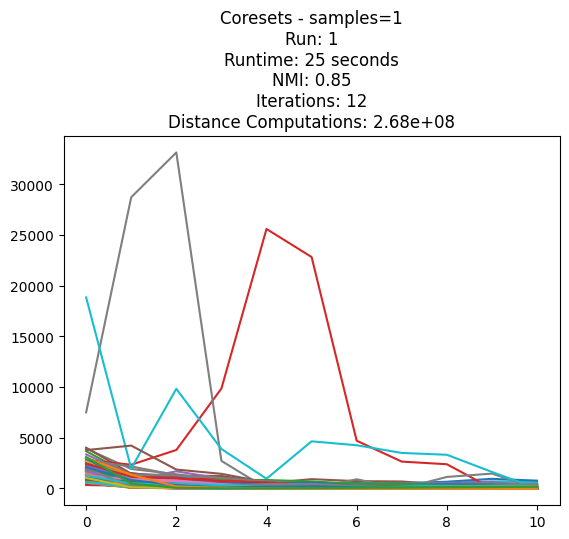

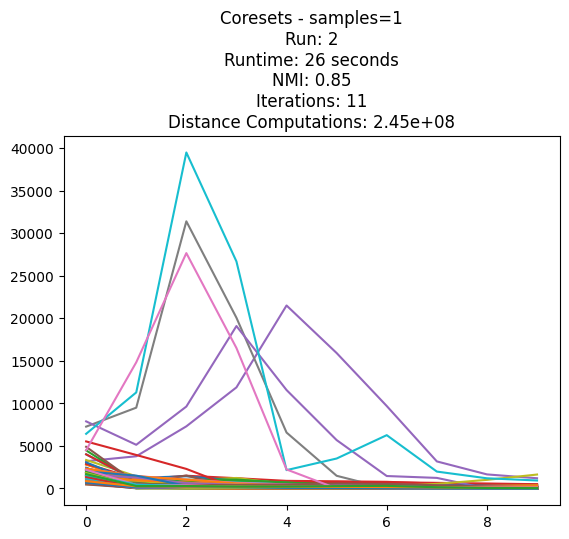

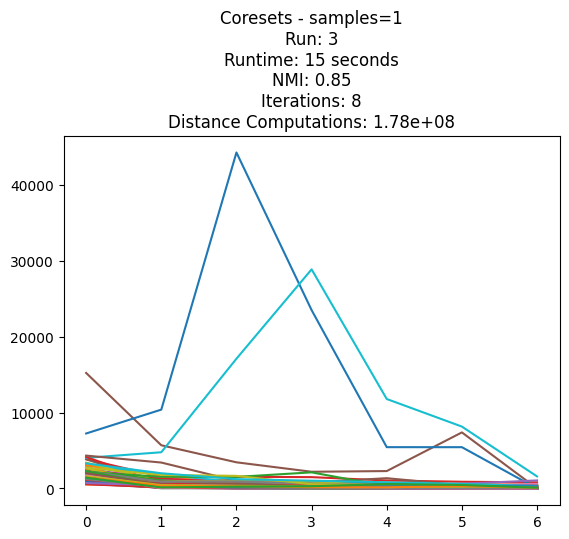

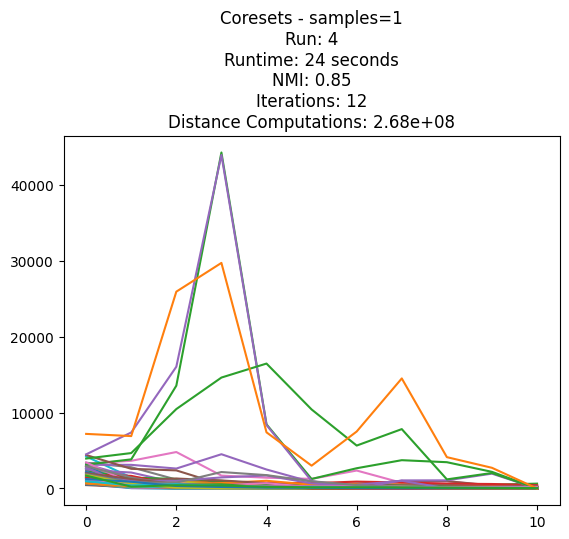

In [149]:
for samples in 1,:
    coresets_title = f'Coresets - samples={samples}'
    # report[coresets_title] = benchmark(X, k, 5, method='coresets', title=coresets_title, samples=samples)
    report[coresets_title] = benchmark(X, k, 5, method='lyod', title=coresets_title, samples=samples)


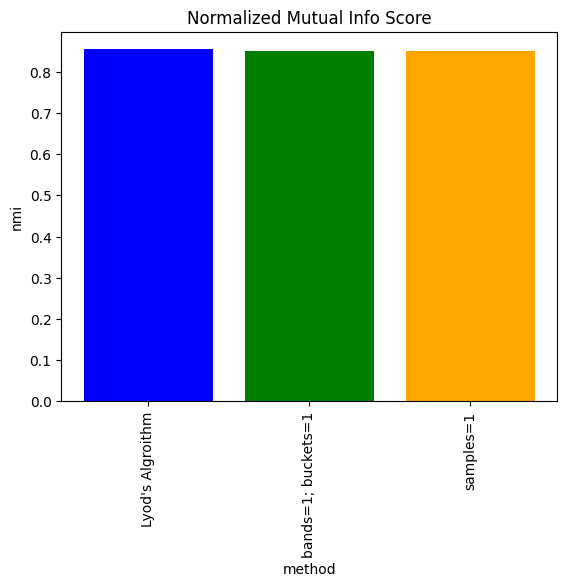

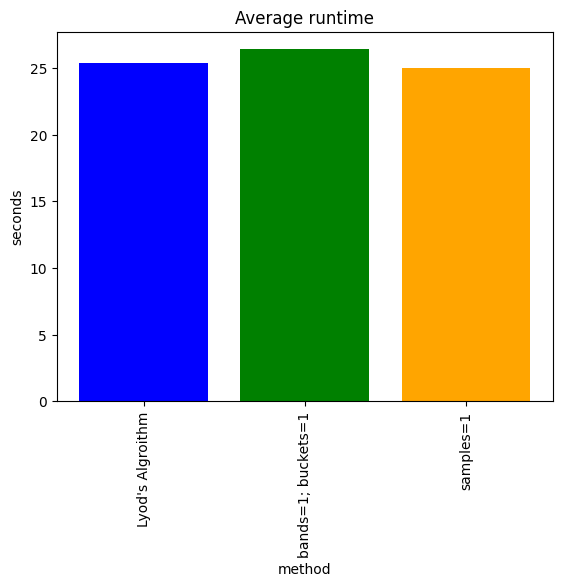

In [164]:
for metric in 'nmi', 'runtime':

    fig, ax = plt.subplots()
    plt.xticks(rotation=90)

    for key, val in report.items():
        ax.set_xlabel('method')
        if metric == 'nmi':
            measure = val[0]
            ax.set_title('Normalized Mutual Info Score')
            ax.set_ylabel('nmi')
        elif metric == 'runtime':
            measure = val[1]
            ax.set_title('Average runtime')
            ax.set_ylabel('seconds')
        if key.startswith('Lyod'):
            ax.bar(key, measure, color='blue')
        elif key.startswith('Local'):
            ax.bar(key.split(' - ')[1], measure, color='green')
        elif key.startswith('Core'):
            ax.bar(key.split(' - ')[1], measure, color='orange')
        